In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data import load_data
from utils import TRAINPATH, save_pickle, load_pickle, LANDMARK_DICT, PICKLEDPATH
from plot import *
from pose import poses_for_dataset
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [13]:
shuffle = True
subset = False

# Load the data
dataset, dataloader = load_data(path=TRAINPATH, batch_size=None, shuffle=shuffle, subset=subset, classify=False)

### Only need to run if you aren't loading from pickle

In [58]:
# Do the pose estimation
estimated_poses, annotated_images = poses_for_dataset(dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


In [69]:
type(estimated_poses[0].pose_landmarks)

mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList

In [67]:
type(estimated_poses[0].pose_world_landmarks)

mediapipe.framework.formats.landmark_pb2.LandmarkList

In [86]:
def pose_to_dataframe(estimated_poses, dataset, pose_var):
    all_val = []
    visib_val = []
    for_numpy = []
    for i in range(len(estimated_poses)):
        if estimated_poses[i]:
            val = []
            visib = []
            nump = []
            for land in getattr(estimated_poses[i], pose_var).landmark:
                x = land.x
                y = land.y
                z = land.z
                vis = land.visibility
                val.append([x,y,z,vis])
                nump.append([x,y,z])
                visib.append(vis)
            all_val.append(val)
            visib_val.append(visib)
            for_numpy.append(nump)
        else:
            all_val.append([None])
            visib_val.append([None])
            
    df = pd.DataFrame.from_records(all_val)
    df_vis = pd.DataFrame.from_records(visib_val)

    df = df.rename(LANDMARK_DICT, axis=1)
    df_vis = df_vis.rename(LANDMARK_DICT, axis=1)
    
    labels = []
    for _, label in dataset:
        labels.append(label)
    df['label'] = labels
    df_vis['label'] = labels
    
    labels_drop_na = np.array(df_vis.dropna(axis=0, how='any')['label'])
    
    return df, df_vis, np.array(for_numpy), labels_drop_na
    
# NOTE NUMPY DATA TAKES OUT NULLS, will have to take out nulls in labels
df, df_vis, numpy_data, labels_drop_na = pose_to_dataframe(estimated_poses, dataset, pose_var='pose_landmarks')
df_world, df_vis_world, numpy_data_world, _ = pose_to_dataframe(estimated_poses, dataset, pose_var='pose_world_landmarks')

In [ ]:
save_pickle(df, PICKLEDPATH, "pose_landmark_all_df.pickle")
save_pickle(df_vis, PICKLEDPATH, "pose_landmark_vis_df.pickle")
save_pickle(numpy_data, PICKLEDPATH, "pose_landmark_numpy.pickle")
save_pickle(df_world, PICKLEDPATH, "pose_world_landmark_all_df.pickle")
save_pickle(df_vis_world, PICKLEDPATH, "pose_world_landmark_vis_df.pickle")
save_pickle(numpy_data_world, PICKLEDPATH, "pose_world_landmark_numpy.pickle")
save_pickle(labels_drop_na, PICKLEDPATH, "labels_drop_na.pickle")
save_pickle(annotated_images, PICKLEDPATH, "annotated_images.pickle")

#### Otherwise can load from pickle

In [7]:
df = load_pickle(PICKLEDPATH, "pose_landmark_all_df.pickle")
df_vis = load_pickle(PICKLEDPATH, "pose_landmark_vis_df.pickle")
numpy_data = load_pickle(PICKLEDPATH, "pose_landmark_numpy.pickle")
df_world = load_pickle(PICKLEDPATH, "pose_world_landmark_all_df.pickle")
df_vis_world = load_pickle(PICKLEDPATH, "pose_world_landmark_vis_df.pickle")
numpy_data_world = load_pickle(PICKLEDPATH, "pose_world_landmark_numpy.pickle")
labels_drop_na = load_pickle(PICKLEDPATH, "labels_drop_na.pickle")
annotated_images = load_pickle(PICKLEDPATH, "annotated_images.pickle")

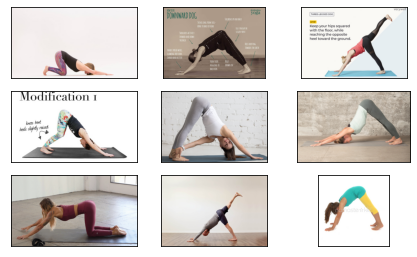

In [87]:
def plot_dataset_images(num):
    images, labels = [], []
    i = 0
    for image, label in dataset:
        i+=1
        images.append(image)
        labels.append(labels)
        if i >=num: break
    
    plot_image_grid(images, len(images), dataloader=True)
    
plot_dataset_images(9)

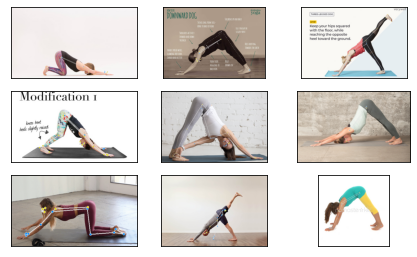

In [88]:
def plot_annotated_images(num):    
    annotated_plot = []
    for im in annotated_images:
        if im is None:
            annotated_plot.append([[0, 0], [0, 0]])
        else:
            annotated_plot.append(im)
    plot_image_grid(annotated_plot[:num], len(annotated_plot[:num]))
    
plot_annotated_images(9)

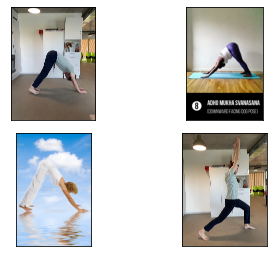

In [89]:
def plot_no_pose_photo(df, dataset, num=9):
    indx_null = df.index[df["NOSE"].isnull()].tolist()
    
    bad_photos = []
    i=0
    for ind in indx_null:
        if i>num: break
        bad_photos.append(dataset[ind][0])
        i+=1
        
    plot_image_grid(bad_photos, len(bad_photos), dataloader=True)
    
plot_no_pose_photo(df, dataset, 20)

In [90]:
print(f"There are {sum(df['NOSE'].isna())} images we don't get a pose estimate for out \
of {len(dataset)}. This is {sum(df['NOSE'].isna())/len(dataset)*100:.2f}%")

There are 4 images we don't get a pose estimate for out of 100. This is 4.00%


In [91]:
df_vis = df_vis.dropna(axis=0, how='any')

In [92]:
df_vis.describe()

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX,label
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.991236,0.986924,0.985219,0.987374,0.991243,0.992781,0.995323,0.985742,0.988194,0.979936,...,0.999335,0.302684,0.712738,0.476665,0.726281,0.612646,0.718792,0.605234,0.725097,0.229167
std,0.045013,0.057944,0.075001,0.059806,0.040144,0.038043,0.020352,0.084624,0.059978,0.099702,...,0.001067,0.321760,0.422305,0.330492,0.417536,0.274392,0.401179,0.275004,0.407814,0.422503
min,0.639651,0.549622,0.389964,0.533650,0.696915,0.701068,0.855823,0.249437,0.521872,0.166290,...,0.992990,0.004131,0.000276,0.036828,0.001506,0.111221,0.004143,0.111611,0.002874,0.000000
25%,0.997404,0.992377,0.995756,0.993778,0.995203,0.998172,0.997201,0.997251,0.997081,0.992026,...,0.999295,0.025435,0.138159,0.172769,0.225521,0.365730,0.306840,0.356436,0.381732,0.000000
50%,0.999378,0.998572,0.998829,0.998761,0.999160,0.999478,0.999477,0.999327,0.999207,0.998337,...,0.999779,0.167106,0.978072,0.372514,0.984976,0.601092,0.952354,0.572319,0.975502,0.000000
75%,0.999856,0.999727,0.999778,0.999815,0.999847,0.999911,0.999893,0.999899,0.999875,0.999702,...,0.999970,0.483747,0.994635,0.836389,0.996715,0.878957,0.995618,0.875368,0.996283,0.000000
max,0.999994,0.999987,0.999992,0.999992,0.999995,0.999995,0.999996,0.999997,0.999992,0.999974,...,0.999999,0.995755,0.999977,0.998683,0.999988,0.998666,0.999983,0.997916,0.999985,1.000000


In [93]:
df_vis.mean().sort_values(ascending=False)

RIGHT_HIP           0.999335
LEFT_HIP            0.999130
RIGHT_SHOULDER      0.998633
LEFT_SHOULDER       0.998073
RIGHT_EYE_OUTER     0.995323
RIGHT_EYE           0.992781
RIGHT_EYE_INNER     0.991243
NOSE                0.991236
RIGHT_EAR           0.988194
LEFT_EYE_OUTER      0.987374
LEFT_EYE_INNER      0.986924
LEFT_EAR            0.985742
LEFT_EYE            0.985219
MOUTH_RIGHT         0.980457
MOUTH_LEFT          0.979936
RIGHT_ANKLE         0.726281
RIGHT_FOOT_INDEX    0.725097
RIGHT_HEEL          0.718792
RIGHT_KNEE          0.712738
RIGHT_ELBOW         0.683905
RIGHT_PINKY         0.652227
RIGHT_WRIST         0.648035
RIGHT_INDEX         0.643138
RIGHT_THUMB         0.614468
LEFT_HEEL           0.612646
LEFT_FOOT_INDEX     0.605234
LEFT_INDEX          0.518445
LEFT_PINKY          0.516925
LEFT_THUMB          0.492594
LEFT_ANKLE          0.476665
LEFT_WRIST          0.392484
LEFT_KNEE           0.302684
LEFT_ELBOW          0.262029
label               0.229167
dtype: float64

In [94]:
numpy_data.shape

(96, 33, 3)

In [95]:
numpy_data[0]

array([[ 0.60068804,  0.93756503, -0.06190197],
       [ 0.61285388,  0.92357302, -0.05035568],
       [ 0.61285245,  0.91983527, -0.05057083],
       [ 0.61277992,  0.91605037, -0.05051634],
       [ 0.61282033,  0.92395365, -0.08707594],
       [ 0.61272669,  0.92051435, -0.08743621],
       [ 0.61264956,  0.91703784, -0.08756768],
       [ 0.61160207,  0.89027798,  0.01668094],
       [ 0.61108965,  0.8930015 , -0.15224706],
       [ 0.5900957 ,  0.9242782 , -0.02923578],
       [ 0.59034115,  0.92328537, -0.0805048 ],
       [ 0.57238817,  0.84550691,  0.09767506],
       [ 0.57576454,  0.85971224, -0.1933215 ],
       [ 0.6504603 ,  0.90557039,  0.1147729 ],
       [ 0.66601855,  0.93501914, -0.2878879 ],
       [ 0.72719324,  0.92647338, -0.00377051],
       [ 0.74856675,  0.93497306, -0.2598007 ],
       [ 0.73818678,  0.9060356 , -0.01531144],
       [ 0.75768793,  0.92468786, -0.30144754],
       [ 0.73986459,  0.91685915, -0.04278829],
       [ 0.76087403,  0.90934145, -0.285

In [96]:
x = numpy_data[0][:,0]
y = numpy_data[0][:,1]

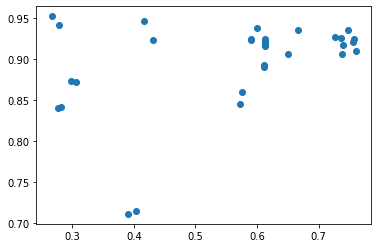

In [97]:
plt.scatter(x, y)

In [36]:
annotated_images = [img for img in annotated_images if img is not None]

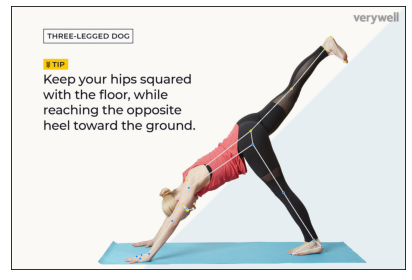

In [103]:
plot_image(annotated_images[2])

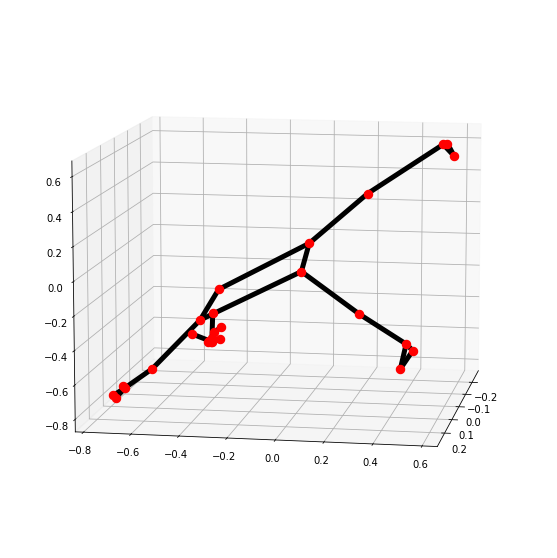

In [104]:
mp_drawing.plot_landmarks(estimated_poses[2].pose_world_landmarks, mp.solutions.pose_connections.POSE_CONNECTIONS)